In [1]:
# # Development mode: automatic reloading of modules
# %load_ext autoreload
# %autoreload 2

In [2]:
import pickle
from tc_python import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from multiprocessing import Pool
import os
from itertools import product
import time
import matplotlib
matplotlib.rcParams['font.family'] = 'FreeSans'

num_cpus = os.cpu_count()
print(f'cpu_count: {num_cpus}')

In [ ]:
basename = 'IronOxide_TC_calculations'

current_directory = os.getcwd()
cache_fname = basename + '.ipynb' + "_cache"
output_fname = os.path.splitext(basename)[0]

print("Cache Filename: ", cache_fname)
print("Output Filename: ", output_fname)
print("Current Dir: ", current_directory)

Cache Filename:  IronOxide_TC_calculations.ipynb_cache
Output Filename:  IronOxide_TC_calculations
Current Dir:  /nethome/home3/yuxiang.wu/IronOxide_TC


### TC functions

#### `tc_calculation_FullEquil`: compute the equilibrium phase fraction as (acr, T)


In [ ]:
def tc_calculation_FullEquil(tk):
    with TCPython() as start:
        batch_calculation = (
            start
            .set_cache_folder(os.path.join(current_directory, cache_fname))
            .set_ges_version(5)
            .select_database_and_elements("tcfe11", ["Fe", "O"])
            .deselect_phase("*")
            .select_phase("BCC_A2 LIQUID")
            .select_database_and_elements("ssub5", ["Fe", "O"])
            .deselect_phase("*")
            .select_phase("HEMATITE MAGNETITE WUSTITE GAS")
            .get_system()
            .with_batch_equilibrium_calculation()
            .set_condition("T", 100+273.15)
            .set_condition("P", 0.5)
            .set_condition("lnacr(o)", -400)
            .with_reference_state("O", 'GAS', tk, 10000)
            .disable_global_minimization()
        )

        # Generate condition combinations for equilibrium calculations
        k = 150
        list_of_conditions = [(("lnacr(o)", lnacr_o), ("T", tk))
                              for lnacr_o in np.linspace(-60, -5, k)]

        batch_calculation.set_conditions_for_equilibria(list_of_conditions)

        results = batch_calculation.calculate(
            ["np(HEMATITE)", "np(MAGNETITE)", "np(WUSTITE)", "np(BCC_A2)", "np(LIQUID)"], 100)

        return (
            list_of_conditions,
            results.get_values_of('np(HEMATITE)'),
            results.get_values_of('np(MAGNETITE)'),
            results.get_values_of('np(WUSTITE)'),
            results.get_values_of('np(BCC_A2)'),
            results.get_values_of('np(LIQUID)')
        )

#### `tc_calculation_Gmin`: compute the Gibbs energy as (database, phase, acr, T)


In [ ]:
def tc_calculation_Gmin(tk, db, phase):
    with TCPython() as start:
        batch_calculation = (
            start
            .set_cache_folder(os.path.join(current_directory, cache_fname))
            .set_ges_version(5))

        # Conditional logic to select database and phase
        if db == 'ssub5':
            batch_calculation = (
                batch_calculation
                .select_database_and_elements(db, ["Fe", "O"])
                .deselect_phase("*")
                .select_phase(f"{phase} GAS")
            )
        else:
            batch_calculation = (
                batch_calculation
                .select_database_and_elements(db, ["Fe", "O"])
                .deselect_phase("*")
                .select_phase(phase)
                .select_database_and_elements('ssub5', ["Fe", "O"])
                .deselect_phase("*")
                .select_phase("GAS")
            )

        # Continue with the rest of the method chain
        batch_calculation = (
            batch_calculation
            .get_system()
            .with_batch_equilibrium_calculation()
            .set_condition("T", 100+273.15)
            .set_condition("P", 0.5)
            .set_condition("lnacr(o)", -400)
            .with_reference_state("O", 'GAS', tk, 10000)
            .disable_global_minimization()
        )

        # Generate condition combinations for equilibrium calculations
        k = 150
        list_of_conditions = [(("lnacr(o)", lnacr_o), ("T", tk))
                              for lnacr_o in np.linspace(-60, -5, k)]

        batch_calculation.set_conditions_for_equilibria(list_of_conditions)

        # run a calculation first
        results = batch_calculation.calculate([f"gm({phase})"], 100)

        # # turn "GAS" into Dormant and run the same calculation again
        # batch_calculation.set_phase_to_dormant("GAS")
        # results = batch_calculation.calculate([f"gm({phase})"], 100)

        return (
            list_of_conditions,
            results.get_values_of(f"gm({phase})")
        )

#### `tc_calculation_NormDrivingForce`: compute the Normalised Driving Force as (database, phase, acr, T)


In [ ]:
def tc_calculation_NormDrivingForce(tk, db, phase):
    with TCPython() as start:
        batch_calculation = (
            start
            .set_cache_folder(os.path.join(current_directory, cache_fname))
            .set_ges_version(5))

        # Conditional logic to select database and phase
        if db == 'ssub5':
            batch_calculation = (
                batch_calculation
                .select_database_and_elements(db, ["Fe", "O"])
                .deselect_phase("*")
                .select_phase(f"{phase} GAS")
            )
        else:
            batch_calculation = (
                batch_calculation
                .select_database_and_elements(db, ["Fe", "O"])
                .deselect_phase("*")
                .select_phase(phase)
                .select_database_and_elements('ssub5', ["Fe", "O"])
                .deselect_phase("*")
                .select_phase("GAS")
            )

        # Continue with the rest of the method chain
        batch_calculation = (
            batch_calculation
            .get_system()
            .with_batch_equilibrium_calculation()
            .set_condition("T", 100+273.15)
            .set_condition("P", 0.5)
            .set_condition("lnacr(o)", -400)
            .set_phase_to_dormant(phase)
            .with_reference_state("O", 'GAS', tk, 10000)
            .disable_global_minimization()
        )

        # Generate condition combinations for equilibrium calculations
        k = 150
        list_of_conditions = [(("lnacr(o)", lnacr_o), ("T", tk))
                              for lnacr_o in np.linspace(-60, -5, k)]

        batch_calculation.set_conditions_for_equilibria(list_of_conditions)

        # run a calculation first
        results = batch_calculation.calculate([f"dgm({phase})"], 100)

        return (
            list_of_conditions,
            results.get_values_of(f"dgm({phase})")
        )

### Parallelising TC calculation


In [ ]:
start_time = time.time()

# paralleising FullEquil
tk_values = np.arange(0+273.15, 605+273.15, 5)
print("temperature range first and last 5 values: ",
      tk_values[:5], tk_values[-5:])
print("FullEquil processes: ", len(tk_values))

# parallelising Gmin and DGM
databases_phases = {
    "ssub5": ["HEMATITE", "MAGNETITE", "WUSTITE"],
    "tcfe11": ["BCC_A2", "LIQUID"]
}

Gmin_DGM_args = []
for tk in tk_values:
    for db, phases in databases_phases.items():
        for phase in phases:
            Gmin_DGM_args.append((tk, db, phase))

print("args for Gmin/DGM parallelisation: ",
      Gmin_DGM_args[:5])
print("Gmin/DGM processes: ", len(Gmin_DGM_args))

# %%%%% load data or run calculations %%%%%
try:
    with open("FullEquil_results.pkl", "rb") as f:
        FullEquil_results = pickle.load(f)
    with open("Gmin_results.pkl", "rb") as f:
        Gmin_results = pickle.load(f)
    with open("DGM_results.pkl", "rb") as f:
        DGM_results = pickle.load(f)
    print("Loaded saved results.")
except FileNotFoundError:
    print("Saved results not found. Running calculations.")

    # run the large calculation
    with Pool(processes=num_cpus-1) as pool:
        FullEquil_results = pool.map(tc_calculation_FullEquil, tk_values)
        Gmin_results = pool.starmap(tc_calculation_Gmin, Gmin_DGM_args)
        DGM_results = pool.starmap(
            tc_calculation_NormDrivingForce, Gmin_DGM_args)

    # Save the results
    with open("FullEquil_results.pkl", "wb") as f:
        pickle.dump(FullEquil_results, f)
    with open("Gmin_results.pkl", "wb") as f:
        pickle.dump(Gmin_results, f)
    with open("DGM_results.pkl", "wb") as f:
        pickle.dump(DGM_results, f)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

elapsed_time = time.time() - start_time
print("Time taken: ", int(elapsed_time), "seconds")

temperature range first and last 5 values:  [273.15 278.15 283.15 288.15 293.15] [853.15 858.15 863.15 868.15 873.15]
FullEquil processes:  121
args for Gmin/DGM parallelisation:  [(273.15, 'ssub5', 'HEMATITE'), (273.15, 'ssub5', 'MAGNETITE'), (273.15, 'ssub5', 'WUSTITE'), (273.15, 'tcfe11', 'BCC_A2'), (273.15, 'tcfe11', 'LIQUID')]
Gmin/DGM processes:  605
Loaded saved results.
Time taken:  0 seconds


#### checking results


In [ ]:
# check again how many processes:
print("number of processes - FullEquil: ", len(FullEquil_results))
print("number of processes - Gmin: ", len(Gmin_results))
print("number of processes - DGM: ", len(DGM_results))

# in each process: list_of_conditions+'np(HEMATITE)'+'np(MAGNETITE)'+'np(WUSTITE)'+'np(BCC_A2)'+'np(LIQUID)'
print("#data categories in each process - FullEquil: ",
      len(FullEquil_results[0]))

# in each process: list_of_conditions+'gm(phase)'
print("#data categories in each process - Gmin: ", len(Gmin_results[0]))

# in each process: list_of_conditions+'dgm(phase)'
print("#data categories in each process - DGM: ",  len(DGM_results[0]))

# the data length inside the above outputs categories
print("data length inside - FullEquil: ", len(FullEquil_results[0][0]))
print("data length inside - Gmin: ", len(Gmin_results[0][1]))
print("data length inside - DGM: ", len(DGM_results[0][1]))

number of processes - FullEquil:  121
number of processes - Gmin:  605
number of processes - DGM:  605
#data categories in each process - FullEquil:  6
#data categories in each process - Gmin:  2
#data categories in each process - DGM:  2
data length inside - FullEquil:  150
data length inside - Gmin:  150
data length inside - DGM:  150


### Unpack the calculation results


#### Analyse FullEquil results


In [ ]:
# Merge results from different processes
list_of_conditions = [res[0] for res in FullEquil_results]
list_np_HEMATITE = [res[1] for res in FullEquil_results]
list_np_MAGNETITE = [res[2] for res in FullEquil_results]
list_np_WUSTITE = [res[3] for res in FullEquil_results]
list_np_BCC_A2 = [res[4] for res in FullEquil_results]
list_np_LIQUID = [res[5] for res in FullEquil_results]

# print(len(list_of_conditions))

# Flattening the lists
list_of_conditions = [
    item for sublist in list_of_conditions for item in sublist]
list_np_HEMATITE = [item for sublist in list_np_HEMATITE for item in sublist]
list_np_MAGNETITE = [item for sublist in list_np_MAGNETITE for item in sublist]
list_np_WUSTITE = [item for sublist in list_np_WUSTITE for item in sublist]
list_np_BCC_A2 = [item for sublist in list_np_BCC_A2 for item in sublist]
list_np_LIQUID = [item for sublist in list_np_LIQUID for item in sublist]

# print(len(list_of_conditions))

# list_np_FCC_L12_merge = [max(a, b, c) for a, b, c in zip(
#     list_np_FCC_L12, list_np_FCC_L12_1, list_np_FCC_L12_2)]

df_FullEquil = pd.DataFrame(columns=['lnacr_o', 'T', 'np(HEMATITE)',
                                     'np(MAGNETITE)', 'np(WUSTITE)', 'np(BCC_A2)', 'np(LIQUID)'])

# Convert conditions and results to DataFrame
df_FullEquil = pd.DataFrame({
    'lnacr_o': [dict(conditions)['lnacr(o)'] for conditions in list_of_conditions],
    'T': [dict(conditions)['T'] for conditions in list_of_conditions],
    'np(HEMATITE)': list_np_HEMATITE,
    'np(MAGNETITE)': list_np_MAGNETITE,
    'np(WUSTITE)': list_np_WUSTITE,
    'np(BCC_A2)': list_np_BCC_A2,
    'np(LIQUID)': list_np_LIQUID
})

df_FullEquil.to_excel(os.path.join(current_directory,
                                   "tc_df_FullEquil_check.xlsx"), index=False)

display(df_FullEquil.head(3), df_FullEquil.shape)

,lnacr_o,T,np(HEMATITE),np(MAGNETITE),np(WUSTITE),np(BCC_A2),np(LIQUID)
0,-60.000000,273.15,1.0,0.0,0.0,0.0,0.0
1,-59.630872,273.15,1.0,0.0,0.0,0.0,0.0
2,-59.261745,273.15,1.0,0.0,0.0,0.0,0.0


(18150, 7)

#### Analyse Gmin results


In [ ]:
from copy import deepcopy


def process_data(Gmin_DGM_args, Gmin_DGM_results):

    Gmin_gm_values = {}
    Gmin_phase_conditions = {}

    for args, result in zip(Gmin_DGM_args, Gmin_DGM_results):
        tk, db, phase = deepcopy(args)
        conditions, gm_values = deepcopy(result)

        lnacr_o_values = [dict(cond)['lnacr(o)'] for cond in conditions]
        T_values = [dict(cond)['T'] for cond in conditions]

        if phase in Gmin_gm_values:
            Gmin_gm_values[phase].extend(gm_values)
        else:
            Gmin_gm_values[phase] = gm_values

        if phase in Gmin_phase_conditions:
            Gmin_phase_conditions[phase]['lnacr(o)'].extend(lnacr_o_values)
            Gmin_phase_conditions[phase]['T'].extend(T_values)
        else:
            Gmin_phase_conditions[phase] = {
                'lnacr(o)': lnacr_o_values, 'T': T_values}

    return Gmin_gm_values, Gmin_phase_conditions

In [ ]:
phases_list = [phase for db_phases in databases_phases.values()
               for phase in db_phases]
print(phases_list)

print("Length of Gmin_DGM_args:", len(Gmin_DGM_args))
print("Length of Gmin_results:", len(Gmin_results))

Gmin_gm_values, Gmin_phase_conditions = process_data(
    Gmin_DGM_args, Gmin_results)

print("temperature_grid x acc_grid:", 130*250)
print("length of Gmin_gm_values: ", len(Gmin_gm_values['BCC_A2']))

for i, phase in enumerate(phases_list):
    assert Gmin_phase_conditions[phases_list[0]
                                 ] == Gmin_phase_conditions[phase]

Gmin_conditions = Gmin_phase_conditions[phases_list[0]]
print("length of Gmin_conditions: ", len(Gmin_conditions['lnacr(o)']))

['HEMATITE', 'MAGNETITE', 'WUSTITE', 'BCC_A2', 'LIQUID']
Length of Gmin_DGM_args: 605
Length of Gmin_results: 605
temperature_grid x acc_grid: 32500
length of Gmin_gm_values:  18150
length of Gmin_conditions:  18150


In [ ]:
df_Gmin = pd.DataFrame({
    'lnacr_o':  Gmin_conditions['lnacr(o)'],
    'T': Gmin_conditions['T'],
    **{f'gm({phase})': Gmin_gm_values.get(phase, []) for phase in phases_list}
})

df_Gmin.to_excel(os.path.join(current_directory,
                 "tc_df_Gmin_check.xlsx"), index=False)

display(df_Gmin.head(3), df_Gmin.shape)

,lnacr_o,T,gm(HEMATITE),gm(MAGNETITE),gm(WUSTITE),gm(BCC_A2),gm(LIQUID)
0,-60.000000,273.15,-169796.574511,-165818.545525,-144570.853208,-24490.49248,-153732.971103
1,-59.630872,273.15,-169796.574511,-165818.545525,-144570.853208,-25308.13219,-153732.973241
2,-59.261745,273.15,-169796.574511,-165818.545525,-144570.853208,-26118.02405,-153732.974902


(18150, 7)

#### Analyse NormDrivingForce results


In [ ]:
print("Length of Gmin_DGM_args:", len(Gmin_DGM_args))
print("Length of DGM_results:", len(DGM_results))

DGM_dgm_values, DGM_phase_conditions = process_data(
    Gmin_DGM_args, DGM_results)

print("temperature_grid x acc_grid:", 130*250)
print("length of DGM_dgm_values: ", len(DGM_dgm_values['BCC_A2']))

for i, phase in enumerate(phases_list):
    assert DGM_phase_conditions[phases_list[0]
                                ] == DGM_phase_conditions[phase]

DGM_conditions = DGM_phase_conditions[phases_list[0]]
print("length of DGM_conditions: ", len(DGM_conditions['lnacr(o)']))

Length of Gmin_DGM_args: 605
Length of DGM_results: 605
temperature_grid x acc_grid: 32500
length of DGM_dgm_values:  18150
length of DGM_conditions:  18150


In [ ]:
df_DGM = pd.DataFrame({
    'lnacr_o':  DGM_conditions['lnacr(o)'],
    'T': DGM_conditions['T'],
    **{f'dgm({phase})': DGM_dgm_values.get(phase, []) for phase in phases_list}
})

df_DGM.to_excel(os.path.join(current_directory,
                             "tc_df_DGM_check.xlsx"), index=False)

display(df_DGM.head(3), df_DGM.shape)

,lnacr_o,T,dgm(HEMATITE),dgm(MAGNETITE),dgm(WUSTITE),dgm(BCC_A2),dgm(LIQUID)
0,-60.000000,273.15,69.965807,73.120688,73.693881,91.623922,62.892852
1,-59.630872,273.15,70.187283,73.331618,73.883469,91.134553,63.114317
2,-59.261745,273.15,70.408760,73.542548,74.073057,90.648742,63.335785


(18150, 7)

### FullEquil: steping at one temperature


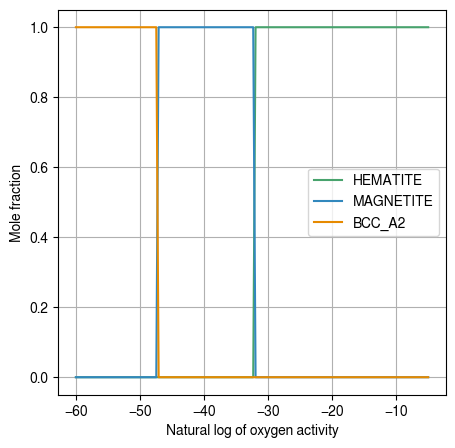

In [ ]:
# Filter the dataframe for rows where T is 373.15
filtered_df_FullEquil = df_FullEquil[df_FullEquil['T'] == 573.15]
filtered_df_FullEquil.to_excel(os.path.join(current_directory,
                                            "tc_df_FullEquil_check_filter.xlsx"), index=False)

plt.figure(figsize=(5, 5))
colors = {
    'HEMATITE': '#48A36D',  # A vibrant teal
    'MAGNETITE': '#3288BD',  # A brighter, more vibrant blue
    'WUSTITE': '#756BB1',  # A vibrant lavender
    'BCC_A2': '#E68A00',  # A strong, vibrant orange
    'LIQUID': '#D43E4F'   # A vibrant, eye-catching coral red
}
labels_list = ['Hematite', 'Magnetite', 'Wustite', 'BCC Iron', 'Liquid']


plt.plot(filtered_df_FullEquil['lnacr_o'], filtered_df_FullEquil['np(HEMATITE)'],
         color=colors['HEMATITE'], label='HEMATITE')
plt.plot(filtered_df_FullEquil['lnacr_o'], filtered_df_FullEquil['np(MAGNETITE)'],
         color=colors['MAGNETITE'], label='MAGNETITE')
# plt.plot(filtered_df_FullEquil['lnacr_o'], filtered_df_FullEquil['np(WUSTITE)'],
#          color=colors['WUSTITE'], label='WUSTITE')
plt.plot(filtered_df_FullEquil['lnacr_o'], filtered_df_FullEquil['np(BCC_A2)'],
         color=colors['BCC_A2'], label='BCC_A2')
# plt.plot(filtered_df_FullEquil['lnacr_o'], filtered_df_FullEquil['np(LIQUID)'],
#          color=colors['LIQUID'], label='LIQUID')

plt.xlabel('Natural log of oxygen activity')
plt.ylabel('Mole fraction')
plt.grid(True)
plt.legend()
# plt.xlim(-100, -25)
plt.show()

### FullEquil: mapping for one phase


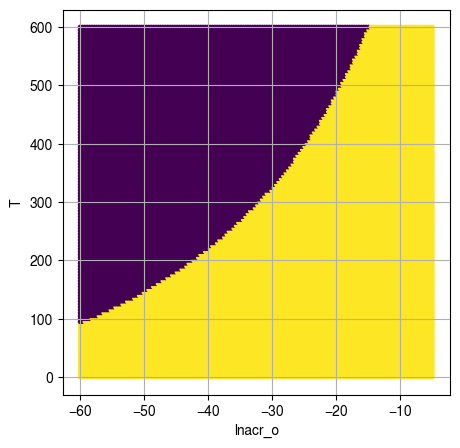

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(df_FullEquil['lnacr_o'], df_FullEquil['T']-273.15,
            c=df_FullEquil['np(HEMATITE)'], s=6,  alpha=1)
plt.xlabel(df_FullEquil.columns[0])
plt.ylabel(df_FullEquil.columns[1])
plt.grid(True)
# plt.legend()
plt.show()

### FullEquil: Mapping for all phases


In [ ]:
# Splitting the main dataframe into individual dataframes and filtering them
df_FullEquil_HEMATITE = df_FullEquil[['lnacr_o', 'T', 'np(HEMATITE)']]
df_FullEquil_HEMATITE = df_FullEquil_HEMATITE[
    df_FullEquil_HEMATITE['np(HEMATITE)'] >= 0.001]

df_FullEquil_MAGNETITE = df_FullEquil[['lnacr_o', 'T', 'np(MAGNETITE)']]
df_FullEquil_MAGNETITE = df_FullEquil_MAGNETITE[
    df_FullEquil_MAGNETITE['np(MAGNETITE)'] >= 0.001]

df_FullEquil_WUSTITE = df_FullEquil[['lnacr_o', 'T', 'np(WUSTITE)']]
df_FullEquil_WUSTITE = df_FullEquil_WUSTITE[df_FullEquil_WUSTITE['np(WUSTITE)']
                                            >= 0.001]

df_FullEquil_BCC_A2 = df_FullEquil[['lnacr_o', 'T', 'np(BCC_A2)']]
df_FullEquil_BCC_A2 = df_FullEquil_BCC_A2[df_FullEquil_BCC_A2['np(BCC_A2)']
                                          >= 0.001]

df_FullEquil_LIQUID = df_FullEquil[['lnacr_o', 'T', 'np(LIQUID)']]
df_FullEquil_LIQUID = df_FullEquil_LIQUID[df_FullEquil_LIQUID['np(LIQUID)']
                                          >= 0.001]

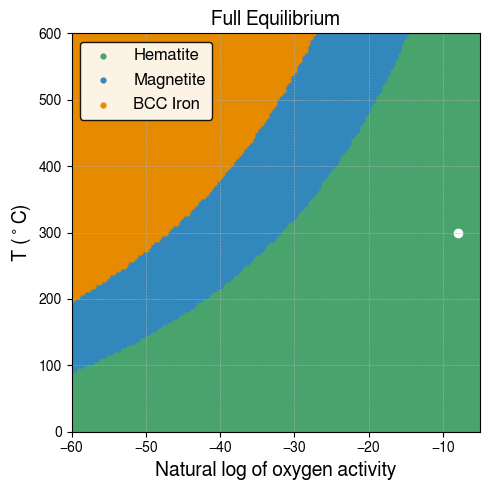

In [ ]:
# Plotting the individual dataframes
plt.figure(figsize=(5, 5))

for i, phase in enumerate(phases_list):
    if phase == "WUSTITE" or phase == "LIQUID":
        pass
    else:
        df = globals()[f'df_FullEquil_{phase}']
        plt.scatter(df['lnacr_o'], df['T']-273.15, s=12,
                    label=labels_list[i],
                    color=colors[phase], alpha=1)
plt.scatter([-7.9663978], [300], color='white')
plt.xlabel('Natural log of oxygen activity', fontsize=14)
plt.ylabel(r'T ($^\circ$C)', fontsize=14)
plt.title('Full Equilibrium', fontsize=14)
plt.legend(fontsize=12, loc='upper left',
           facecolor='white', edgecolor='black', framealpha=0.9)
plt.grid(True, which='both', linestyle='--', linewidth=0.4)
plt.xlim([min(df_Gmin['lnacr_o']), max(df_Gmin['lnacr_o'])])
plt.ylim([min(df_Gmin['T'])-273.15, max(df_Gmin['T'])-273.15])
plt.yticks(range(0, 601, 100))
plt.tight_layout()

plt_output_fname = "IronOxide_TC_FullEquil.png"
plt.savefig(os.path.join(current_directory, plt_output_fname),
            format='png', dpi=300, bbox_inches='tight', )

plt.show()

### Gmin: mapping for individual phase


In [ ]:
display(df_Gmin.head(3), df_Gmin.shape)

,lnacr_o,T,gm(HEMATITE),gm(MAGNETITE),gm(WUSTITE),gm(BCC_A2),gm(LIQUID)
0,-60.000000,273.15,-169796.574511,-165818.545525,-144570.853208,-24490.49248,-153732.971103
1,-59.630872,273.15,-169796.574511,-165818.545525,-144570.853208,-25308.13219,-153732.973241
2,-59.261745,273.15,-169796.574511,-165818.545525,-144570.853208,-26118.02405,-153732.974902


(18150, 7)

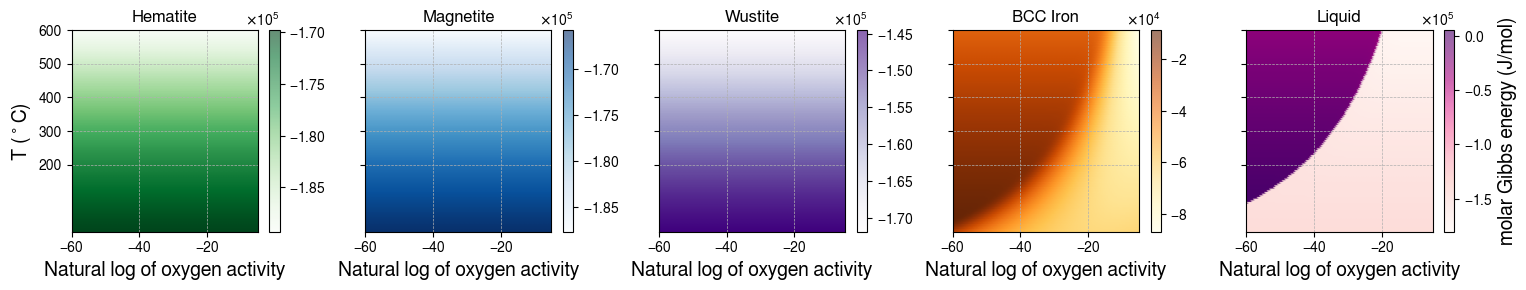

In [ ]:
from matplotlib.ticker import ScalarFormatter

# Define the colormaps for each phase
colormaps = {
    'HEMATITE': 'Greens',
    'MAGNETITE': 'Blues',
    'WUSTITE': 'Purples',
    'BCC_A2': 'YlOrBr',
    'LIQUID': 'RdPu'
}

# Create a new figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(
    phases_list), figsize=(3.1 * len(phases_list), 3), sharex=True, sharey=True)

for i, phase in enumerate(phases_list):

    sc = axs[i].scatter(df_Gmin['lnacr_o'], df_Gmin['T']-273.15,
                        c=df_Gmin[f'gm({phase})'],
                        cmap=colormaps[phase], s=5, alpha=0.6)

    cbar = plt.colorbar(sc, ax=axs[i])

    # Change colorbar numbering to scientific notation
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    cbar.ax.yaxis.set_major_formatter(formatter)

    # Label the colorbar of the last plot only
    if i == len(phases_list) - 1:
        cbar.set_label('molar Gibbs energy (J/mol)', fontsize=14)
    if i == 0:
        axs[i].set_ylabel(r'T ($^\circ$C)', fontsize=14)

    axs[i].set_xlabel('Natural log of oxygen activity', fontsize=14)
    axs[i].set_xlim([min(df_Gmin['lnacr_o']), max(df_Gmin['lnacr_o'])])
    axs[i].set_ylim([min(df_Gmin['T'])-273.15,
                     max(df_Gmin['T'])-273.15])
    axs[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axs[i].set_title(f'{labels_list[i]}')
    axs[i].set_yticks(range(200, 601, 100))
    # axs[i].set_aspect('equal', 'box')

fig.tight_layout()
fig.savefig('IronOxide_TC_Gm_phases.png',
            format='png', dpi=300, bbox_inches='tight')

plt.show()

### Gmin: Mapping for all phases


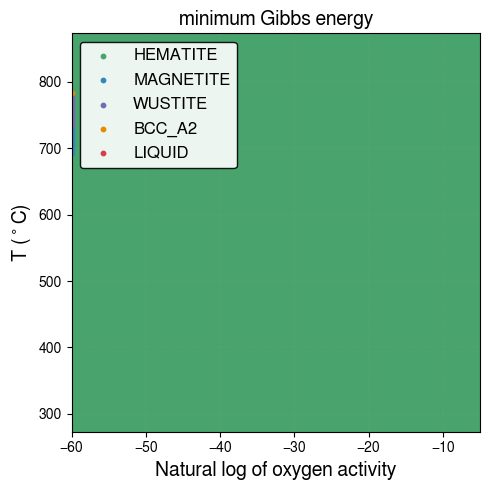

In [ ]:
columns_to_compare = [f'gm({phase})' for phase in phases_list]

for phase in phases_list:
    column_name = f'gm({phase})'
    condition = df_Gmin[column_name] == df_Gmin[columns_to_compare].min(axis=1)
    globals()[f'df_Gmin_{phase}'] = df_Gmin[condition]

# Plotting the individual dataframes
plt.figure(figsize=(5, 5))

for phase in phases_list:
    df = globals()[f'df_Gmin_{phase}']
    plt.scatter(df['lnacr_o'], df['T'], s=10, label=phase,
                color=colors[phase], alpha=1)

plt.xlabel('Natural log of oxygen activity', fontsize=14)
plt.ylabel(r'T ($^\circ$C)', fontsize=14)
plt.title('minimum Gibbs energy', fontsize=14)
plt.legend(fontsize=12, loc='upper left',
           facecolor='white', edgecolor='black', framealpha=0.9)
plt.grid(True, which='both', linestyle='--', linewidth=0.1)
plt.xlim([min(df_Gmin['lnacr_o']), max(df_Gmin['lnacr_o'])])
plt.ylim([min(df_Gmin['T']), max(df_Gmin['T'])])
plt.tight_layout()

# plt_output_fname = "IronOxide_TC_Gmin.png"
# plt.savefig(os.path.join(current_directory, plt_output_fname),
#             format='png', dpi=300, bbox_inches='tight')
plt.show()

### NormDrivingForce: Mapping for individual phase


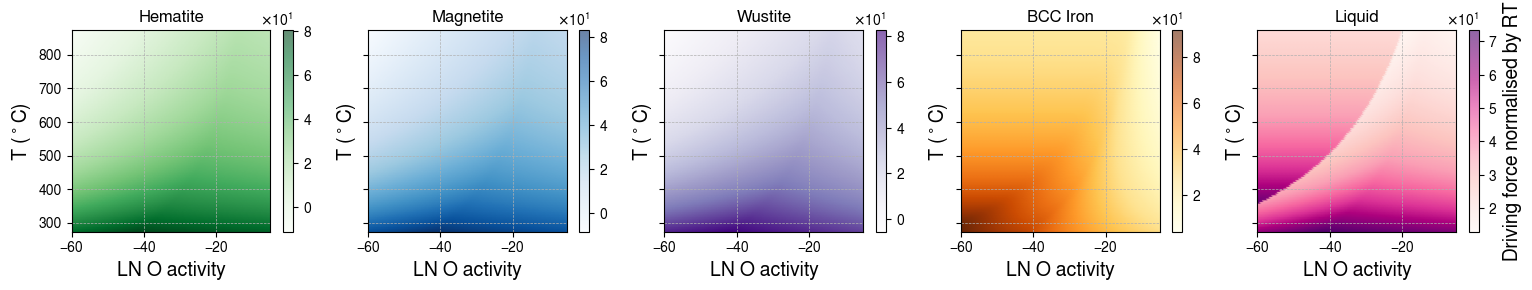

In [ ]:
# Create a new figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(
    phases_list), figsize=(3.1 * len(phases_list), 3), sharex=True, sharey=True)

for i, phase in enumerate(phases_list):

    sc = axs[i].scatter(df_DGM['lnacr_o'], df_DGM['T'],
                        c=df_DGM[f'dgm({phase})'], cmap=colormaps[phase], s=5, alpha=0.6)

    cbar = plt.colorbar(sc, ax=axs[i])

    # Change colorbar numbering to scientific notation
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    cbar.ax.yaxis.set_major_formatter(formatter)

    # Label the colorbar of the last plot only
    if i == len(phases_list) - 1:
        cbar.set_label('Driving force normalised by RT', fontsize=14)

    axs[i].set_xlabel('Natural log of oxygen activity', fontsize=14)
    axs[i].set_ylabel(r'T ($^\circ$C)', fontsize=14)
    axs[i].set_xlim([min(df_DGM['lnacr_o']), max(df_DGM['lnacr_o'])])
    axs[i].set_ylim([min(df_DGM['T']), max(df_DGM['T'])])
    axs[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axs[i].set_title(f'{labels_list[i]}')
    # axs[i].set_aspect('equal', 'box')

fig.tight_layout()
fig.savefig('IronOxide_TC_DGM_phases.png',
            format='png', dpi=300, bbox_inches='tight')

plt.show()


### DGM: Mapping for all phases


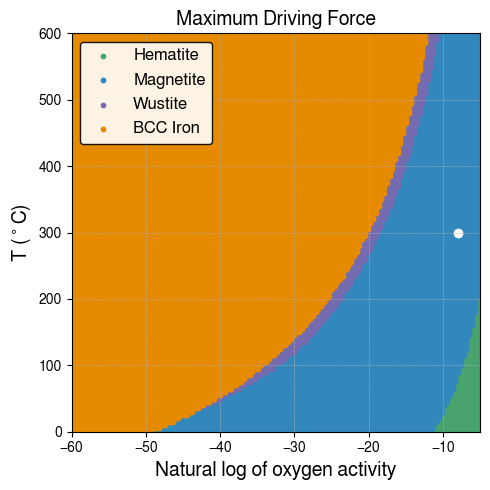

In [ ]:
columns_to_compare = [f'dgm({phase})' for phase in phases_list]
# columns_to_compare = ['dgm(HEMATITE)', 'dgm(MAGNETITE)', 'dgm(WUSTITE)', 'dgm(LIQUID)' ]

for phase in phases_list:
    column_name = f'dgm({phase})'
    condition = df_DGM[column_name] == df_DGM[columns_to_compare].max(axis=1)
    globals()[f'df_DGM_{phase}'] = df_DGM[condition]


# Plotting the individual dataframes
plt.figure(figsize=(5, 5))

for i, phase in enumerate(phases_list):
    if phase == 'LIQUID':
        pass
    else:
        df = globals()[f'df_DGM_{phase}']
        plt.scatter(df['lnacr_o'], df['T']-273.15, s=10, label=labels_list[i],
                    color=colors[phase], alpha=1)
plt.scatter([-7.9663978], [300], color='white')
plt.xlabel('Natural log of oxygen activity', fontsize=14)
plt.ylabel(r'T ($^\circ$C)', fontsize=14)
plt.title('Maximum Chemical Driving Force for Nucleation', fontsize=14)
plt.legend(fontsize=12, loc='upper left',
           facecolor='white', edgecolor='black', framealpha=0.9)
plt.grid(True, which='both', linestyle='--', linewidth=0.4)
plt.xlim([min(df_DGM['lnacr_o']), max(df_DGM['lnacr_o'])])
plt.ylim([min(df_DGM['T'])-273.15, max(df_DGM['T'])-273.15])
plt.tight_layout()

plt_output_fname = "IronOxide_TC_DGMmax.png"
plt.savefig(os.path.join(current_directory, plt_output_fname),
            format='png', dpi=300, bbox_inches='tight')
plt.show()